# Autoencoders for image denoising

## Table of contents
0. [Parameters](#parameters)
1. [Prepare the Data](#prepare)
2. [Build the autoencoder](#build)
3. [Train the autoencoder](#train)
3. [Predict using the autoencoder](#predict)
3. [Denoising using the autoencoder](#denoise)

In [27]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from utils.image import preprocess, noise, display, sample_batch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Parameters <a name="parameters"></a>

In [58]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NOISE_FACTOR = 0.4
EPOCHS = 1

## 1. Prepare the data <a name="prepare"></a>

In [16]:
train_data = image_dataset_from_directory(
    "../../data/lego/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='training',
    interpolation="bilinear",
)

test_data = image_dataset_from_directory(
    "../../data/lego/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=VALIDATION_SPLIT,
    subset='validation',
    interpolation="bilinear",
)

Found 40000 files belonging to 1 classes.
Using 32000 files for training.
Found 40000 files belonging to 1 classes.
Using 8000 files for validation.


In [ ]:
train = train_data.map(lambda x: preprocess(x))
test = test_data.map(lambda x: preprocess(x))

In [38]:
train_sample = sample_batch(train)
test_sample = sample_batch(test)

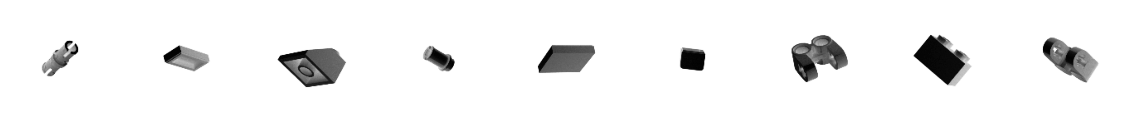

In [39]:
display(train_sample)

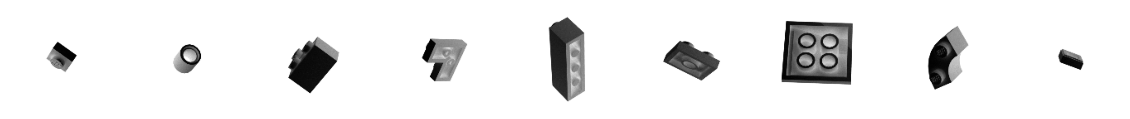

In [40]:
display(test_sample)

In [59]:
noisy_train = train.map(lambda x: noise(x, NOISE_FACTOR))
noisy_test = test.map(lambda x: noise(x, NOISE_FACTOR))

noisy_train_sample = np.array([noise(x, NOISE_FACTOR) for x in train_sample])
noisy_test_sample = np.array([noise(x, NOISE_FACTOR) for x in test_sample])

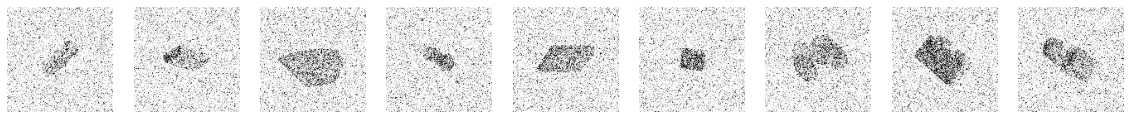

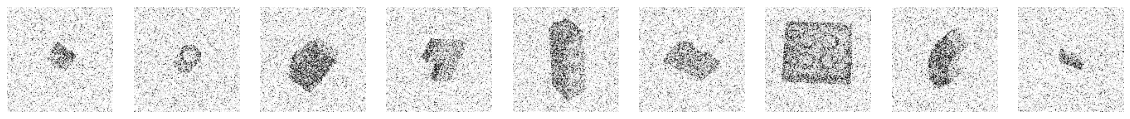

In [60]:
display(noisy_train_sample)
display(noisy_test_sample)

## 2. Build the autoencoder <a name="build"></a>

In [22]:
input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 64, 64, 32)       9248

## 3. Train the autoencoder <a name="train"></a>

In [23]:
train_in = train.map(lambda x : (x, x))
test_in = test.map(lambda x : (x, x))

history = autoencoder.fit(
    train_in,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=test_in,
)

 414/1000 [===========>..................] - ETA: 8:40 - loss: 0.1396


KeyboardInterrupt



## 4. Predict using the autoencoder <a name="train"></a>

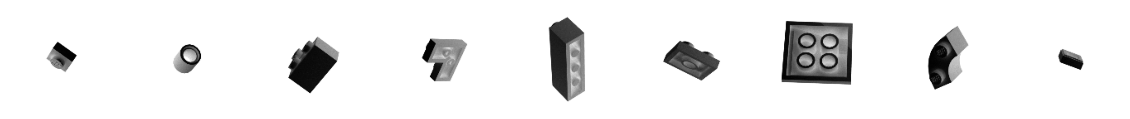

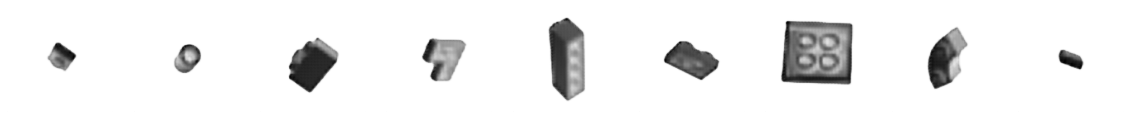

In [55]:
predictions = autoencoder.predict(test_sample)
display(test_sample)
display(predictions)

## 5. Denoise using the autoencoder <a name="denoise"></a>

In [56]:
noisy_train_in = noisy_train.map(lambda x : (x, x))
noisy_test_in = noisy_test.map(lambda x : (x, x))

In [63]:
history = autoencoder.fit(
    noisy_train_in,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=noisy_test_in,
)

1000/1000 [==============================] - 1058s 1s/step - loss: 0.2381 - val_loss: 0.2348


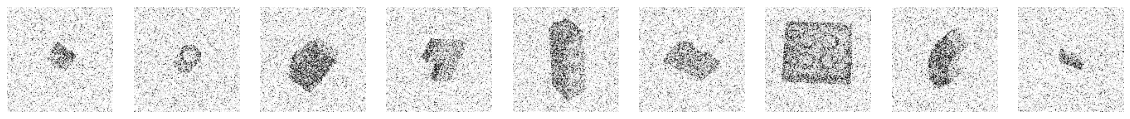

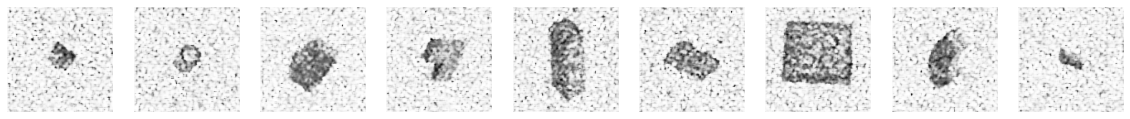

In [64]:
predictions = autoencoder.predict(noisy_test_sample)
display(noisy_test_sample)
display(predictions)